In [387]:
from gaussian import *
from skimage.transform import resize
simulation_attenuation = '/beegfs/desy/user/jentscht/for_dawit/double_sphere_smoothing_3/groundtruth/double_sphere_6000_eV/ground_truth_projection/ground_truth_projection_attenuation_6000_eV_00000_type_float32_8192x8192.tif'
simulation_phase = '/beegfs/desy/user/jentscht/for_dawit/double_sphere_smoothing_3/groundtruth/double_sphere_6000_eV/ground_truth_projection/ground_truth_projection_phase_6000_eV_00000_type_float32_8192x8192.tif'
phase_image_orig = io.imread(simulation_phase) * 2 * np.pi / wavelength_from_energy(6000).magnitude
attenuation_image_orig = io.imread(simulation_attenuation) * 2*np.pi / wavelength_from_energy(6000).magnitude

phase_image = torchnor_phase(phase_image_orig)
attenuation_image = torchnor_phase(attenuation_image_orig)
phase_image = T.Resize((512, 512))(phase_image)
attenuation_image = T.Resize((512, 512))(attenuation_image)

/beegfs/desy/user/hailudaw/anacon/envs/topo/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


using rows:  1 cols:  3


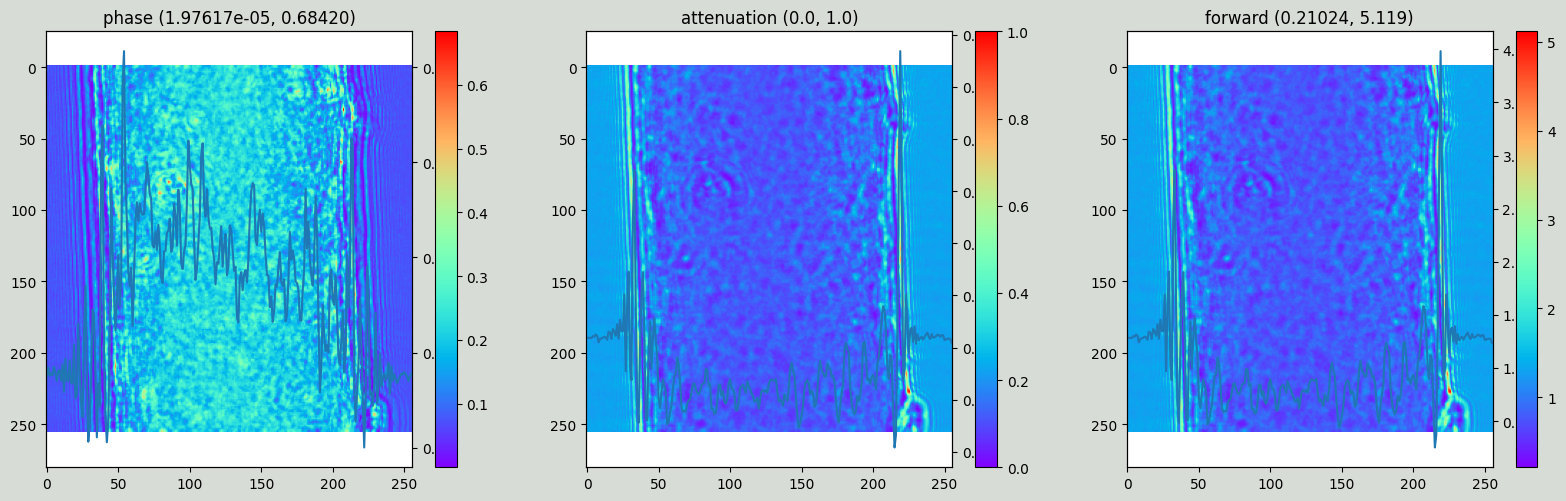

In [509]:
from typing import Any

def get_image(path, idx = None, file_type=None):
    if type(path) is not list:
        if type(path) is str:
            if os.path.isdir(path):
                images = list(io.imread_collection(path + '/*.' + file_type).files)
                
                if idx is None:
                    image_path = path
                    
                else:
                    image_path = [path[i] for i in idx]
                    
                image = load_images_parallel(image_path)
                
            elif os.path.isfile(path):
                image = io.imread(path)
                image_path = path
            
                if len(images.shape) == 2:
                    image = images
                elif len(images.shape) == 3:
                    image = images[idx,:,:] if idx is not None else images
                else:
                    image = images[idx,:,:,:] if idx is not None else images
                image = [image]
        elif 'numpy' in str(type(path)) or 'torch' in str(type(path)) or 'jax' in str(type(path)):
            if len(path.shape) == 2:
                image = path
            elif len(path.shape) == 3:
                image = path[idx,:,:] if idx is not None else path
            else:
                image = path[idx,:,:,:] if idx is not None else path
            image = [image]
            image_path = None
        elif 'ImageCollection' in str(type(path)):
            image_path = path.files
            image_path = [image_path[i] for i in idx] if idx is not None else image_path
            image = load_images_parallel(image_path)
        
        else:
            image = path
            image_path = None
            print("couldn't load image from path")
            pass
    else:
        image = []
        image_path = []
        for p in path:
            image_, image_path_ = get_image(p, idx, file_type)
            image.append(image_)
            image_path.append(image_path_)
    return image, image_path

def get_base_coeff(image):
    image = torch_reshape(image)
    _, _, shape_x, shape_y = image.shape
    freq_1 = torch.fft.fftfreq(shape_x)
    freq_2 = torch.fft.fftfreq(shape_y)
    xi, eta = torch.meshgrid(freq_1, freq_2)
    xi = xi.type(torch.float32)
    eta = eta.type(torch.float32)
    return torch.exp((xi**2 + eta**2)/2)

def ffactors(px, py, energy, zs, pv, fresnel_number = None):
    if fresnel_number == None:
        lambda_p = 1.23984122e-09 / energy
        if type(zs) is not list:
            fresnel_number = pv**2 / (lambda_p * zs)
        else:
            fresnel_number = [pv**2 / (lambda_p * zs[i]) for i in range(len(zs))]
    
    freq_x = fftfreq(px)
    freq_y = fftfreq(py)
    xi, eta = np.meshgrid(freq_x, freq_y)
    xi = xi.astype('float32')
    eta = eta.astype('float32')
    if type(zs) is not list:
        frequ_prefactors = 2 * np.pi  / fresnel_number
        h = np.exp(- 1j * frequ_prefactors * (xi ** 2 + eta ** 2) / 2)
    else:
        frequ_prefactors = [2 * np.pi  / fresnel_number[i] for i in range(len(zs))]
        h = [((np.exp(- 1j * frequ_prefactors[i] * (xi ** 2 + eta ** 2) / 2)).T).astype('complex64') for i in range(len(zs))]
    return h

def prepare_dict(**kwargs):
    similar_terms = [
        ['path', 'images', 'image', 'paths','image', 'i_inputs', 'i_input', 'hologram', 'intensity'],
        ['file_type', 'file_types', 'filetype', 'filetypes'],
        ['idx', 'indices', 'index'],
        ['energy', 'energy_kev'], 
        ['lam', 'lamda', 'wavelength', 'wave_length'],
        ['phase', 'phase_image'],
        ['attenuation', 'attenuation_image'],
        ['detector_pixel_size', 'pv'],
        ['distance_sample_detector', 'z'],
        ['fresnel_number', 'fresnel_number', 'fresnelnumbers', 'fresnelnumbers'],
        ['fresnel_factor', 'ffs', 'frensel_factors', 'fresnelfactor'],
        ['pad', 'pad_value', 'magnification_factor', 'upscale'],
        ['downsampling_factor'],
        ['mode', 'pad_mode'],
        ['experiment_name'],
        ['task', 'method'],
        ['alpha', 'alpha_value'],
        ['abs_ratio'],
        ['delta_beta', 'delta_beta_value'],
        ['shape_x', 'px'],
        ['shape_y', 'py'],
        ]
    for i, terms in enumerate(similar_terms):
        kwargs[terms[0]] = None if terms[0] not in kwargs.keys() else kwargs[terms[0]]
        for term in terms:
            if term in kwargs.keys():
                kwargs[terms[0]] = kwargs[term]
                break

    if kwargs['idx'] is not None:
        kwargs['idx'] = [kwargs['idx']] if type(kwargs['idx']) is not list else kwargs['idx']
  
    dictionary = {'image':None, 'path':None, 'image_path':None, 'pad': 1, 'mode': 'reflect', 'task': 'learn_phase', 'alpha': 1e-8, 'delta_beta': 1e1, 'idx': None, 'file_type': 'tif', 'save_path': os.getcwd() + '/results/', 'idx': 0, 'save': False, 'transform_factor': 0.7, 'transform_type': 'reshape', 'save_format': 'tif', 'save_all': False, 'downsampling_factor': 1, 'fresnel_number': None, 'detector_pixel_size': None, 'distance_sample_detector': None, 'energy': None, 'phase': None, 'attenuation': None}
    dictionary.update(kwargs)
    kwargs = dictionary
    
    assert kwargs['path'] is not None or kwargs['phase'] is not None or kwargs['attenuation'] is not None, "path, phase or attenuation are not provided"
    kwargs['image'], kwargs['image_path'] = get_image(kwargs['path'], kwargs['idx'], kwargs['file_type']) if kwargs['path'] is not None else kwargs['image'], kwargs['image_path']
    try:
        kwargs['image'] = torch_reshape(kwargs['image']) if kwargs['image'] is not None else None
    except:
        kwargs['image'] = torch_reshape(kwargs['image'][0]) if kwargs['image'] is not None else None
    if kwargs['image'] is not None and kwargs['phase'] is None and kwargs['attenuation'] is None:
        kwargs['phase'] = kwargs['image']
        kwargs['attenuation'] = kwargs['image']
    else:
        try:
            kwargs['phase'], kwargs['phase_path'] = get_image(kwargs['phase'], kwargs['idx'], kwargs['file_type']) if kwargs['phase'] is not None else kwargs['phase'], kwargs['phase_path']
        except:
            try:
                kwargs['phase'] = torch_reshape(kwargs['phase'])
                kwargs['attenuation'] = torch_reshape(kwargs['attenuation'])
            except:
                pass


    if kwargs['image'] is not None:
        _, _, shape_x, shape_y = torch_reshape(kwargs['image']).shape
        kwargs['image'] = T.Resize((shape_x//kwargs['downsampling_factor'], shape_y//kwargs['downsampling_factor']), antialias=True)(kwargs['image'])    
        kwargs['transformed_images'] = transform(kwargs['image'], kwargs['transform_type'], kwargs['transform_factor'])
        _, _, kwargs['shape_x'], kwargs['shape_y'] = kwargs['transformed_images'].shape if kwargs['transformed_images'] is not None else kwargs['phase'].shape
    if kwargs['phase'] is not None:
        _, _, shape_x, shape_y = kwargs['phase'].shape
        kwargs['phase'] = T.Resize((shape_x//kwargs['downsampling_factor'], shape_y//kwargs['downsampling_factor']), antialias=True)(kwargs['phase'])
    if kwargs['attenuation'] is not None:
        _, _, shape_x, shape_y = kwargs['attenuation'].shape
        kwargs['attenuation'] = T.Resize((shape_x//kwargs['downsampling_factor'], shape_y//kwargs['downsampling_factor']), antialias=True)(kwargs['attenuation'])

    if kwargs['fresnel_number'] is not None:
        kwargs['fresnel_number'] = kwargs['fresnel_number'] * kwargs['downsampling_factor']**2
    if kwargs['detector_pixel_size'] is not None:
        kwargs['detector_pixel_size'] = kwargs['detector_pixel_size'] * kwargs['downsampling_factor']
    kwargs['downsampling_factor'] = 1

    assert kwargs['phase'] is not None or kwargs['attenuation'] is not None, "phase or attenuation are not provided"
    
    kwargs['shape'] = (kwargs['shape_x'], kwargs['shape_y'])
    return kwargs

class Fresnel_propagation(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
            
        optional_kwargs = {"fresnel_number": None, "distance_sample_detector": None, "detector_pixel_size": None, "energy": None, 'pad': 2, "transform_type": "reshape", "transform_factor": 1, "mode": "reflect", "value": "mean", "downsampling_factor": 1, "wave_field": None, 'fresnel_factor': None, 'device': 'cuda:0'}
        alternative_names = {"energy_kev": "energy", "E": "energy", "z": "distance_sample_detector", "z12": "distance_sample_detector", "pv": "detector_pixel_size", "pv": "effective_pixel_size", 'z_eff':'distance_sample_detector', 'dxeff': 'detector_pixel_size'}

        optional_kwargs.update(kwargs)

        for key, value in alternative_names.items():
            if key in optional_kwargs.keys():
                optional_kwargs[value] = kwargs[key]
        kwargs.update(prepare_dict(**optional_kwargs))

        for key, value in kwargs.items():
            self.__setattr__(key, value)

        assert self.phase is not None or self.attenuation is not None, "phase or attenuation are not provided"
        self.wavefield = self.get_wavefield(compute_new_ff = False)
        _, _, new_shape_x, new_shape_y = self.wavefield.shape
        self.fresnel_number = fresnel_calc(self.energy, self.distance_sample_detector, self.detector_pixel_size) if self.fresnel_number is None else self.fresnel_number
        self.base_matrix = torch_reshape(get_base_coeff(self.wavefield)) if self.wavefield is not None else None
        self.fresnel_factor = torch_reshape(ffactors(px = new_shape_x, py = new_shape_y, energy = self.energy, zs = self.distance_sample_detector, pv = self.detector_pixel_size, fresnel_number= self.fresnel_number)) if self.fresnel_factor is None else self.fresnel_factor
        self.image = self.forward() if self.image == None else self.image
        self.transformed_images = transform(self.image, self.transform_type, self.transform_factor)
  
    def get_wavefield(self, phase = None, compute_new_ff = False, attenuation = None, downsampling_factor = None, pad = None, mode = None, value = None):
        downsampling_factor = 1 if compute_new_ff == False else downsampling_factor
        pad = self.pad if pad is None else pad
        mode = self.mode if mode is None else mode
        value = self.value if value is None else value
        phase = self.phase if phase is None else phase
        attenuation = self.attenuation if attenuation is None else attenuation

        #resize the phase and attenuation images by the downsampling factor
        if downsampling_factor > 1:
            phase = torch_reshape(phase)
            phase = T.Resize((phase.shape[2]//downsampling_factor, phase.shape[3]//downsampling_factor), antialias=True)(self.phase)
            attenuation = torch_reshape(attenuation)
            attenuation = T.Resize((attenuation.shape[2]//downsampling_factor, attenuation.shape[3]//downsampling_factor), antialias=True)(self.attenuation)
        else:
            phase = torch_reshape(phase)
            attenuation = torch_reshape(attenuation)
        wavefield = torch.exp(torch.complex(-attenuation, phase))
        #now padding, 
        _, _, shape_x, shape_y = wavefield.shape
        if mode == 'constant':
            values = ['mean', 'median', 'min', 'max', 'zero', 'one']
            if value in values:
                if value == 'mean':
                    value_real = torch.mean(wavefield.real)
                    value_imag = torch.mean(wavefield.imag)
                elif value == 'median':
                    value_real = torch.median(wavefield.real)
                    value_imag = torch.median(wavefield.imag)
                elif value == 'min':
                    value_real = torch.min(wavefield.real)
                    value_imag = torch.min(wavefield.imag)
                elif value == 'max':
                    value_real = torch.max(wavefield.real)
                    value_imag = torch.max(wavefield.imag)
                elif value == 'zero':
                    value_real = 0
                    value_imag = 0
                elif value == 'one':
                    value_real = 1
                    value_imag = 1
            else:
                value_real = value
                value_imag = value

            wavefield_real = F.pad(wavefield.real, (int((shape_y*pad - shape_y)/2), int((shape_y *pad- shape_y)/2), int((shape_x *pad- shape_x)/2), int((shape_x *pad- shape_x)/2)), mode = mode, value = value_real)
            wavefield_imag = F.pad(wavefield.imag, (int((shape_y*pad - shape_y)/2), int((shape_y *pad- shape_y)/2), int((shape_x *pad- shape_x)/2), int((shape_x *pad- shape_x)/2)), mode = mode, value = value_imag)
            wavefield = torch.complex(wavefield_real, wavefield_imag)
        else:
            wavefield = F.pad(wavefield, (int((shape_y*pad - shape_y)/2), int((shape_y *pad- shape_y)/2), int((shape_x *pad- shape_x)/2), int((shape_x *pad- shape_x)/2)), mode)
        return wavefield
    
    def forward(self, phase = None, attenuation = None, pad = None, mode = None, value = None, compute_new_ff = False, fresnel_factor = None, energy = None, distance_sample_detector = None, detector_pixel_size = None, fresnel_number = None, base_coeff = None, wavefield = None):
        """
        If the phase and attenuation are provided, it uses them to create the wavefield. Otherwise, it uses the wavefield provided.
        this function propagates the wavefield from the sample to the detector. If fresnel_factor is not provided, it calculates it.

        You can use the **dataloader.kwargs() as an input to this function:
        """
        phase = self.phase if phase is None else torch_reshape(phase)
        attenuation = self.attenuation if attenuation is None else torch_reshape(attenuation)
        _, _, shape_x, shape_y = phase.shape
        wavefield = self.get_wavefield(phase = phase, attenuation = attenuation, compute_new_ff = compute_new_ff, downsampling_factor = self.downsampling_factor, pad = pad, mode = mode, value = value) if wavefield is None else wavefield
        
        assert wavefield is not None and 'complex' in str(wavefield.dtype), "wavefield is not provided or is not complex"
        if compute_new_ff == True:
            energy = self.energy if energy is None else energy
            distance_sample_detector = self.distance_sample_detector if distance_sample_detector is None else distance_sample_detector
            detector_pixel_size = self.detector_pixel_size if detector_pixel_size is None else detector_pixel_size
            fresnel_number = fresnel_calc(energy, distance_sample_detector, detector_pixel_size) if fresnel_number is None else fresnel_number
            fresnel_number = fresnel_number * self.downsampling_factor**2 if self.downsampling_factor > 1 else fresnel_number
            base_matrix = torch_reshape(get_base_coeff(wavefield)) if base_coeff is None else base_coeff
            fresnel_factor = torch_reshape(ffactors(px = shape_x, py = shape_y, energy = energy, zs = distance_sample_detector, pv = detector_pixel_size, fresnel_number = self.fresnel_number)) if fresnel_factor is None else fresnel_factor
        else:
            
            fresnel_factor = self.fresnel_factor if fresnel_factor is None else fresnel_factor
        self.propagated_wavefield = torch.fft.ifft2(fresnel_factor * torch.fft.fft2(wavefield))
        intenstiy = torch.abs(self.propagated_wavefield)**2
        self.intensity = intenstiy[:, :, int((intenstiy.shape[2] - shape_x)/2):int((intenstiy.shape[2] + shape_x)/2), int((intenstiy.shape[3] - shape_y)/2):int((intenstiy.shape[3] + shape_y)/2)]
        return self.intensity
    
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return super().__call__(*args, **kwds)

class make_ganrec_model(nn.Module):
    def __init__(self, **kwargs):
        super(make_ganrec_model, self).__init__()
        
        basic_setup = {'transform_factor': 0.7,'transform_type': 'reshape', 'pad':2, 'mode': 'reflect', 'value': 'min', 'device': 'cuda:0', 'iter_num': 110, 'abs_ratio': 0.05, 'input_channels': 1, 'output_num': 2, 'task': 'learn_phase', 'seed': 49, 'fc_depth': 0, 'units': 1024, 'cnn_depth': 0, 'dis_depth': 3, 'stride': 1, 'depth': 3, 'conv_num': 32, 'conv_size': 3, 'dropout': 0.25, 'apply_batchnorm': True, 'normal_init': True, 'ground_truth': None, 'init_model': False, 'init_model_path': 'model/ganrec_model'}
        basic_setup.update(kwargs)
        basic_setup.update(prepare_dict(**basic_setup))
        for key, value in basic_setup.items():
            setattr(self, key, value)

        print(basic_setup['transformed_images'].shape)

        if 'ground_truth' in self.__dict__.keys():
            self.ground_truth = transform(self.ground_truth, self.transform_type, self.transform_factor)
            self.ground_truth = to_device(T.Resize((self.shape_x, self.shape_y), antialias=True)(self.ground_truth), self.device)

        # if 'transformed_images' not in kwargs.keys():
        #     if 'image' in kwargs.keys():
        #         self.image = kwargs['image']
        #     elif 'path' in kwargs.keys():
        #         if 'idx' not in kwargs.keys():
        #             kwargs['idx'] = None
        #         if 'file_type' not in kwargs.keys():
        #             kwargs['file_type'] = 'tif'
        #         self.image = torch_reshape(get_image(kwargs['path'], kwargs['idx'], kwargs['file_type'])[0])
        #     else:
        #         if 'phase' in kwargs.keys() and 'attenuation' in kwargs.keys():
        #             self.image = Fresnel_propagation.forward(**self.__dict__)
        #             self.transformed_images = transform(self.image, self.transform_type, self.transform_factor)
        #         else:
        #             raise ValueError('image, phase and attenuation are not provided')

        # self.transformed_images = transform(self.image, self.transform_type, self.transform_factor)
        self.transformed_images = to_device(self.transformed_images, self.device)
        print('transformed_images shape: ', self.transformed_images.shape, 'transform_type: ', self.transform_type, 'transform_factor: ', self.transform_factor, 'phase_shape: ', self.phase.shape, 'attenuation_shape: ', self.attenuation.shape, 'image_shape: ', self.image.shape)
        

        self.create_seed()
        self.generator(**self.__dict__)
        self.discriminator(**self.__dict__)
        self.define_task(**kwargs)
        self.criterion(**kwargs)
        self.easy_transformed_images()

    def create_seed(self, seed = None):
        if seed is None:
            seed = self.seed
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

    def generator(self, **kwargs):
        ##################################################################################################
        # We first define the generator model
        ##################################################################################################
        options = {'fc_depth': 0, 'units': 128, 'depth':3, 'cnn_depth': 0, 'conv_num': 32, 'conv_size': 3, 'dropout': 0.25, 'apply_batchnorm': True, 'normal_init': True, 'device': 'cuda:0'}
        options.update(self.__dict__)
        [setattr(self, key, value) for key, value in options.items()]


        if self.fc_depth == 0:
            self.fc_stack = []
        else:
            units = [self.units]*self.fc_depth
            self.fc_submodule = nn.ModuleList([
                dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout) for i in range(len(units))
            ])
            self.fc_stack = nn.ModuleList([
                nn.Flatten(),
                Transpose(),
                dense_layer(in_features=1, out_features=self.units, dropout=self.dropout, transpose=False),
                *self.fc_submodule,
                dense_layer(in_features=self.units, out_features=1, dropout=0),
                Reshape((-1, 1, self.shape_x, self.shape_y)),
            ])

        if self.cnn_depth == 0:
            self.cnn_stack = []
        else:
            conv_size_add_list = list(np.arange(1,self.cnn_depth+1))
            deconv_size_add_list = list(np.arange(self.cnn_depth, 0, -1))
            self.conv_stack = nn.ModuleList([
                conv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+conv_size_add_list[i], stride=1, apply_batchnorm=True, normal_init=True) for i in range(len(conv_size_add_list))
            ])

            self.dconv_stack = nn.ModuleList([
                deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+deconv_size_add_list[i], stride=1, apply_batchnorm=True, normal_init=True) for i in range(len(deconv_size_add_list))
            ])
            self.cnn_stack = nn.ModuleList([      
                conv2d_layer(in_channels=1, out_channels=self.conv_num, kernel_size=self.conv_size, stride=1), 
                *self.conv_stack[0:],
                *self.dconv_stack,
                deconv2d_layer(in_channels=self.conv_num, out_channels=self.output_num, kernel_size=self.conv_size, stride=1),
            ])
        
        if self.depth == 0:
            self.generator_model = to_device(nn.Sequential(
                *self.fc_stack,
                *self.cnn_stack,
            ), self.device)
        else:
            self.generator_model = to_device(nn.Sequential(*self.fc_stack, UNet(n_channels=self.input_channels, n_classes=self.output_num, bilinear=True)), self.device)

        if 'init_model' in kwargs.keys():
            if kwargs['init_model']:
                # Load the model
                init_model_path = kwargs.get('init_model_path', 'model/ganrec_model')
                self.generator_model.load_state_dict(torch.load(init_model_path))

        else:
            self.init_weights()
    
    def discriminator(self, **kwargs):
        # ##################################################################################################
        # # We then define the discriminator model
        # ##################################################################################################
        options = {'dis_depth': 3, 'conv_num': 3, 'device': 'cuda:0'}
        for key, value in options.items():
            if key not in self.__dict__.keys():
                setattr(self, key, value)
        in_channels_list = list(2**np.arange(self.dis_depth)) # [1, 16, 16, 32, 32]
        out_channels_list =list(2**np.arange(1,self.dis_depth+1)) #[16, 16, 32, 32, 64]
        kernel_size_list = [self.conv_num]*len(in_channels_list) #[3,3,3,3,3]
        stride_list = [1]*len(in_channels_list) #[2,2,2,2,2]
        discriminator_stack = nn.ModuleList([
            conv2d_layer(in_channels=in_channels_list[i], out_channels=out_channels_list[i], kernel_size=kernel_size_list[i], stride=stride_list[i]) for i in range(len(in_channels_list))
        ])

        self.discriminator_model =  to_device(nn.Sequential(
            *discriminator_stack,
            nn.Flatten(),
        ), self.device)

        if 'init_model' in kwargs.keys():
            if kwargs['init_model']:
                # Load the model
                init_model_path = kwargs.get('init_model_path', 'model/ganrec_model')
                self.discriminator_model.load_state_dict(torch.load(init_model_path))
        else:
            self.init_weights()

    def define_task(self, task = None, **kwargs):
        # ##################################################################################################
        # # We then define the task
        # ##################################################################################################
        if task is None:
            if self.task is None or 'task' not in kwargs.keys():
                self.task = 'learn_phase'
        else:
            self.task = task

        if self.task == 'learn_gaussian':
            self.gaussian_filter = to_device(Gaussian_challenge(self.transformed_images, kernel_size=self.gaussian_kernel_size, sigma=self.sigma), self.device)
        else:  
            self.fresnel_propagator = to_device(Fresnel_propagation(**self.__dict__), self.device)
            self.fresnel_factor = to_device(self.fresnel_propagator.fresnel_factor, self.device)
            self.base_matrix = to_device(self.fresnel_propagator.base_matrix, self.device)

            # self.propagated_intensity = self.fresnel_propagator.forward(wavefield = self.wavefield, fresnel_factor = self.fresnel_factor)
            # print('propagated_intensity: ', self.propagated_intensity.shape)

    def criterion(self, **kwargs):
        self.ssim = to_device(SSIM(), self.device)
        self.psnr = to_device(PSNR(), self.device)
        self.mssim = to_device(mSSIM(), self.device)
        # self.fid.update(self.transformed_images, real=True)
        
    def easy_transformed_images(self, image = None):
        image = self.transformed_images if image is None else image
        self.reshaped = to_device(transform(image, 'reshape') , self.device)
        self.normalized = transform(self.reshaped, 'normalize')
        self.norm = transform(self.reshaped, 'norm')
        self.contrast = transform(self.reshaped, 'contrast', self.transform_factor)
        self.contrast_normalize = transform(self.reshaped, 'constrast_normalize', self.transform_factor)
        self.brightness = transform(self.reshaped, 'brightness', self.transform_factor)
        self.brightness_normalize = transform(self.reshaped, 'brightness_normalize', self.transform_factor)
        self.fourier = torch.fft.fft2(self.reshaped)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def run_different_scenarios(self, df , i):
        df.loc[i, 'iter_num'] = len(self.gen_loss_list)
        df.loc[i, 'gen_loss'] = self.gen_loss_list[-1]
        df.loc[i, 'dis_loss'] = self.dis_loss_list[-1]
        df.loc[i, 'main_diff'] = self.main_diff_list[-1]
        df.loc[i, 'ssim_list'] = self.ssim_list[-1]
        df.loc[i, 'psnr_list'] = self.psnr_list[-1]
        df.loc[i, 'mssim_list'] = self.mssim_list[-1]
        df.loc[i, 'setup_info'] = get_file_nem(self.__dict__)
        if self.ground_truth is not None:
            df.loc[i, 'ground_ssim_list'] = self.ground_ssim_list[-1]
            df.loc[i, 'ground_psnr_list'] = self.ground_psnr_list[-1]
            df.loc[i, 'ground_mssim_list'] = self.ground_mssim_list[-1]
            df.loc[i, 'ground_main_diff_list'] = self.ground_main_diff_list[-1]
        return df
    
    def refine_parameters_using_condition(self, condition = None, values = None, change_from_soure = False, info = None, ratio = None, plot_pd=False, show_images=False, cmap = 'gray'):
        if ratio is None:
            ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 0, 'brightness_ratio': 0, 'reg_l1_ratio': 0.001, 'reg_l2_ratio': 0.001, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 0, 'norm_ratio': 0, 'entropy_ratio': 1, 'real_loss_ratio': 1, 'fake_loss_ratio': 1}
        
        
        last_unblurred_images = []
        last_phases = []
        last_atts = []
        last_props = []
        all_df = []
        if self.ground_truth is not None:
            df = pd.DataFrame(columns=['gen_loss', 'dis_loss', 'main_diff', 'ssim_list', 'psnr_list', 'mssim_list', 'setup_info', 'ground_ssim_list', 'ground_psnr_list', 'ground_mssim_list', 'ground_main_diff_list', 'epoch_time'])
        else:
            df = pd.DataFrame(columns=['gen_loss', 'dis_loss', 'main_diff', 'ssim_list', 'psnr_list', 'mssim_list', 'setup_info', 'epoch_time'])
        
        if type(ratio) is list:
            df.index.name = 'ratios'
            
            for i, r in enumerate(ratio):
                model = make_ganrec_model(**self.__dict__)
                if self.task == 'learn_gaussian':
                    model.train(save_model = False, save_model_path = 'model/ganrec_model', **r)
                    last_unblurred_images.append(model.unblurred_list[-1])
                    last_props.append(model.propagated_intensity_list[-1])
                    
                else:
                    model.train(save_model = False, save_model_path = 'model/ganrec_model', **r)
                    last_phases.append(model.phase_list[-1])
                    last_atts.append(model.attenuation_list[-1])
                    last_props.append(model.propagated_intensity_list[-1])

                print('gen_loss: ', model.gen_loss_list[-1], 'dis_loss: ', model.dis_loss_list[-1], 'main_diff: ', model.main_diff_list[-1])
                df.loc[i, 'iter_num'] = len(model.gen_loss_list)
                df.loc[i, 'gen_loss'] = model.gen_loss_list[-1]
                df.loc[i, 'dis_loss'] = model.dis_loss_list[-1]
                df.loc[i, 'main_diff'] = model.main_diff_list[-1]
                df.loc[i, 'ssim_list'] = model.ssim_list[-1]
                df.loc[i, 'psnr_list'] = model.psnr_list[-1]
                df.loc[i, 'mssim_list'] = model.mssim_list[-1]
                df.loc[i, 'setup_info'] = get_file_nem(model.__dict__)
            #replace nan values with 0
            df = df.fillna(0)
            column_range = ['main_diff', 'gen_loss', 'dis_loss', 'ssim_list', 'psnr_list', 'mssim_list']
            #list_element.index(element)
            min_vals = [df[column].min() for column in column_range], [df[column].idxmin() for column in column_range]
            max_vals = [df[column].max() for column in column_range], [df[column].idxmax() for column in column_range]
            
            if plot_pd:         
                plot_pandas(df, column_range=column_range)
            if show_images:
                if self.task == 'learn_gaussian':
                    visualize(last_unblurred_images, title = ['unblurred_' + str(i) for i in range(len(last_unblurred_images))], cmap = cmap)
                    visualize(last_props, title = ['propagated_intensity_' + str(i) for i in range(len(last_props))], cmap = cmap)
                else:
                    visualize(last_props, title = ['propagated_intensity_' + str(i) for i in range(len(last_props))], cmap=cmap)
                    visualize(last_phases, title = ['phase_' + str(i) for i in range(len(last_phases))], cmap=cmap)

            if self.task == 'learn_gaussian':
                return df, last_unblurred_images, last_props, min_vals, max_vals
            else:
                return df, last_props, last_phases, last_atts, min_vals, max_vals
        else:
            df.index.name = condition

            if type(values) is not list:
                values = [values]

            for i, value in enumerate(values):    
                if change_from_soure == True:
                    info[condition] = value if condition in info.keys() else info.update({condition: value})
                    new_dataloader = Ganrec_Dataloader(**info)
                    model = make_ganrec_model(**new_dataloader.__dict__)
                else:
                    kwargs = self.__dict__
                    kwargs[condition] = value if condition in kwargs.keys() else kwargs.update({condition: value})
                    model = make_ganrec_model(**kwargs)

                if self.task == 'learn_gaussian':
                    model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
                    last_unblurred_images.append(model.unblurred_list[-1])
                    last_props.append(model.propagated_intensity_list[-1])

                else:
                    model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
                    last_phases.append(model.phase_list[-1])
                    last_atts.append(model.attenuation_list[-1])
                    last_props.append(model.propagated_intensity_list[-1])
                all_df += [model.df]

                print('gen_loss: ', model.gen_loss_list[-1], 'dis_loss: ', model.dis_loss_list[-1], 'main_diff: ', model.main_diff_list[-1])
                df = self.run_different_scenarios(df, i)
                
            #concatenate all the dataframes
            all_df = pd.concat(all_df)    
            #replace nan values with 0
            df = df.fillna(0)
            if self.ground_truth is None:
                column_range = ['main_diff', 'gen_loss', 'dis_loss', 'ssim_list', 'psnr_list', 'mssim_list']
            else:
                column_range = ['main_diff', 'gen_loss', 'dis_loss', 'ssim_list', 'psnr_list', 'mssim_list', 'ground_ssim_list', 'ground_psnr_list', 'ground_mssim_list', 'ground_main_diff_list']
            #list_element.index(element)
            min_vals = [df[column].min() for column in column_range], [df[column].idxmin() for column in column_range]
            max_vals = [df[column].max() for column in column_range], [df[column].idxmax() for column in column_range]

            if plot_pd:
                plot_pandas(df, column_range=column_range)
                plot_pandas(all_df, column_range=column_range)
            if show_images:
                if self.task == 'learn_gaussian':
                    visualize(last_unblurred_images, title = ['unblurred_' + str(i) for i in range(len(last_unblurred_images))], cmap = cmap)
                    visualize(last_props, title = ['propagated_intensity_' + str(i) for i in range(len(last_props))], cmap = cmap)
                else:
                    visualize(last_props, title = ['propagated_intensity_' + str(i) for i in range(len(last_props))], cmap=cmap)
                    visualize(last_phases, title = ['phase_' + str(i) for i in range(len(last_phases))], cmap=cmap)

            if self.task == 'learn_gaussian':
                return df, last_unblurred_images, last_props, min_vals, max_vals
            else:
                return df, last_props, last_phases, last_atts, min_vals, max_vals

    def make_model(self):
        # self.generator_model = self.generator(**self.__dict__)
        # self.discriminator_model = self.discriminator(**self.__dict__)
        if 'g_learning_rate' not in self.__dict__.keys():
            self.g_learning_rate = 1e-5
        if 'd_learning_rate' not in self.__dict__.keys():
            self.d_learning_rate = 1e-8
        if 'weight_decay' not in self.__dict__.keys():
            self.weight_decay = 1e-8
        if 'momentum' not in self.__dict__.keys():
            self.momentum = 0.9
        if 'amp' not in self.__dict__.keys():
            self.amp = False

        self.generator_optimizer = optim.RAdam(self.generator_model.parameters(),lr=self.g_learning_rate, weight_decay=self.weight_decay)
        self.discriminator_optimizer = optim.Adam(self.discriminator_model.parameters(), lr=self.d_learning_rate, weight_decay=self.weight_decay, amsgrad=True, maximize=True)
        
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.generator_optimizer, 'min', patience=5)  # goal: maximize Dice score
        self.grad_scaler = torch.cuda.amp.GradScaler(enabled=self.amp)    
        
    def transform(self, x):
        if 'transform_type' in self.kwargs.keys():
            transform_type = self.transform_type
        else:
            transform_type = 'normalize'

        if 'transform_factor' in self.kwargs.keys():
            transform_factor = self.transform_factor
        else:
            transform_factor = 0.1
        return transform(x, transform_type, transform_factor)

    def propagator(self):
        self.phase = transform(self.pred[:,0,:,:], 'normalize') -1 # * torch.pi
        self.attenuation =  (1 - transform(self.pred[:,1,:,:], 'normalize'))*self.abs_ratio
        propagated_intensity = transform(self.fresnel_propagator.forward(self.phase, self.attenuation, fresnel_factor = self.fresnel_factor, base_coeff = self.base_matrix, compute_new_ff = False), self.transform_type, self.transform_factor)
        self.difference = propagated_intensity - self.transformed_images
        self.main_diff = torch.mean(torch.abs(self.difference))
        self.phase = transform(self.phase, self.transform_type, self.transform_factor)

        return propagated_intensity, self.phase, self.attenuation
    
    def gaussian_conv(self, x = None):
        if x is None:
            x = self.transform(self.pred)
        else:
            if self.output_num == 1:
                x = transform(x, 'reshape')
            elif self.output_num == 2:
                self.phase = x[:,0,:,:]
                self.attenuation = x[:,1,:,:]
                self.modulus = torch_reshape(torch.abs(torch.exp(1j*self.phase) * torch.exp(-self.attenuation))**2)
                x = torch_reshape(self.phase)
            # x = self.transform(x)
        self.blurred = to_device((self.gaussian_filter(x)), self.device)
        self.difference = self.blurred - self.transformed_images
        if self.l1_ratio != 0:
            self.main_diff = torch.mean(torch.abs(self.difference))
        else:
            self.main_diff = torch.mean(torch.square(self.difference))
        return self.blurred, x
        
    def forward(self, x = None):
        x = self.transformed_images if x is None else x
        self.pred = self.generator_model(x)
        propagated_intensity, phase, attenuation = self.propagator()
        self.fake_output = self.discriminator_model(propagated_intensity)
        self.real_output = self.discriminator_model(x)
        return self.fake_output, self.real_output, propagated_intensity, phase, attenuation
    
    def forward_gaussian(self, x):
        self.pred = self.generator_model(x)
        self.propagated_intensity, self.unblurred = self.gaussian_conv(self.pred)
        self.fake_output = self.discriminator_model(self.propagated_intensity)
        self.real_output = self.discriminator_model(x)
        return self.fake_output, self.real_output, self.propagated_intensity, self.unblurred
    
    def generator_loss(self, fake_output, x, propagated_intensity):
        cross_entropy = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.ones_like(fake_output)))
        if self.l1_ratio == 0:
            l2_loss = self.main_diff if self.l2_ratio != 0 else 0
            l1_loss = 0
        else:
            l1_loss =self.main_diff if self.l1_ratio != 0 else 0
            l2_loss = torch.mean(torch.square(self.difference)) if self.l2_ratio != 0 else 0
        
        contrast_diff = torch.mean(torch.abs(self.contrast - transform(propagated_intensity, 'contrast', self.transform_factor))) if self.contrast_ratio != 0 else 0
        contrast_noramlize_difference = torch.mean(torch.square(self.contrast_normalize - transform(propagated_intensity, 'contrast_normalize', self.transform_factor))) if self.contrast_normalize_ratio != 0 else 0
        brightness_noramlize_difference = torch.mean(torch.square(self.brightness_normalize - transform(propagated_intensity, 'brightness_normalize', 1 - self.transform_factor))) if self.brightness_normalize_ratio != 0 else 0
        brightness_diff = torch.mean(torch.square(self.brightness - transform(propagated_intensity, 'brightness', 1 - self.transform_factor))) if self.brightness_ratio != 0 else 0
        
        norm_diff = torch.mean(torch.abs(self.norm - transform(propagated_intensity, 'norm', self.transform_factor))) if self.norm_ratio != 0 else 0
        normalized_diff = torch.mean(torch.abs(self.normalized - transform(propagated_intensity, 'normalize', self.transform_factor))) if self.normalized_ratio != 0 else 0
        
        #use logaritmic loss for the fourier difference
        fourier_diff_real = torch.mean(torch.square(torch.log(torch.abs(torch.fft.fft2(propagated_intensity).real + 1e-10)))) if self.fourier_ratio != 0 else 0
        fourier_diff_imag = torch.mean(torch.square(torch.log(torch.abs(torch.fft.fft2(propagated_intensity).imag + 1e-10)))) if self.fourier_ratio != 0 else 0
        fourier_diff = fourier_diff_real + fourier_diff_imag
        #we use a truncated - quadratic gradient regularization
        reg_l2_loss = torch.mean(torch.square(self.pred[:, :, 1:, :] - self.pred[:, :, :-1, :])) + torch.mean(torch.square((self.pred[:, :, :, 1:] - self.pred[:, :, :, :-1]))) if self.reg_l2_ratio != 0 else 0
        if reg_l2_loss > 0: 
            reg_l2_loss = 1 if reg_l2_loss >1 else reg_l2_loss
            
        reg_l1_loss = torch.mean(torch.abs(self.pred[:, :, 1:, :] - self.pred[:, :, :-1, :])) + torch.mean(torch.abs((self.pred[:, :, :, 1:] - self.pred[:, :, :, :-1]))) if self.reg_l1_ratio != 0 else 0
        if self.epoch > self.iter_num//10:
            self.reg_l1_ratio = 0
            self.reg_l2_ratio = 0
        #if self.modulus exists, then make sure
        self.final_loss =  self.entropy_ratio * cross_entropy + self.l1_ratio * l1_loss + self.contrast_ratio * contrast_diff + self.norm_ratio * norm_diff + self.normalized_ratio * normalized_diff + self.brightness_ratio * brightness_diff + self.contrast_normalize_ratio * contrast_noramlize_difference + self.brightness_normalize_ratio * brightness_noramlize_difference + self.l2_ratio * l2_loss + self.fourier_ratio * fourier_diff
        return self.final_loss + reg_l2_loss * self.reg_l2_ratio + reg_l1_loss * self.reg_l1_ratio
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output)))
        fake_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output)))
        self.total_loss = self.real_loss_ratio * real_loss + self.fake_loss_ratio * fake_loss
        return self.total_loss
    
    def train_step(self, x):
        self.generator_optimizer.zero_grad()
        self.discriminator_optimizer.zero_grad()
        if self.task == 'learn_gaussian':
            self.fake_output, self.real_output, self.propagated_intensity, self.unblurred = self.forward_gaussian(x)
        else:
            self.fake_output, self.real_output, self.propagated_intensity, self.phase, self.attenuation = self.forward(x)
        self.gen_loss = self.generator_loss(self.fake_output, x, self.propagated_intensity)
        self.dis_loss = self.discriminator_loss(self.real_output, self.fake_output)
        self.gen_loss.backward(retain_graph=True)
        self.dis_loss.backward()
        self.generator_optimizer.step()
        self.discriminator_optimizer.step()
        if self.task == 'learn_gaussian':
            return self.gen_loss, self.dis_loss, self.propagated_intensity, self.unblurred
        else:
            return self.gen_loss, self.dis_loss, self.propagated_intensity, self.phase, self.attenuation
        
    def train(self, iter_num = None, save_model = None, save_model_path = None, **ratio): # l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, norm_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 0, brightness_normalize_ratio = 0, l2_ratio = 0, fourier_ratio = 0):
        for key, value in ratio.items():
            setattr(self, key, value)
        iter_num = self.iter_num if iter_num is None else iter_num
        save_model = self.save_model if save_model is None else save_model
        save_model_path = self.save_model_path if save_model_path is None else save_model_path

        self.make_model()
        self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list, self.main_diff_list, self.epoch_time, self.ssim_list, self.psnr_list, self.mssim_list = [], [], [], [], [], [], [], [], [], []
        self.ground_main_diff_list, self.ground_ssim_list, self.ground_psnr_list, self.ground_mssim_list = [], [], [], []
        if self.task == 'learn_gaussian':
            self.unblurred_list = []

        if self.ground_truth is not None:
            self.df = pd.DataFrame(columns=['gen_loss', 'dis_loss', 'main_diff', 'ssim_list', 'psnr_list', 'mssim_list', 'setup_info', 'ground_ssim_list', 'ground_psnr_list', 'ground_mssim_list', 'ground_main_diff_list', 'epoch_time'])

        else:
            self.df = pd.DataFrame(columns=['gen_loss', 'dis_loss', 'main_diff', 'ssim_list', 'psnr_list', 'mssim_list', 'setup_info', 'epoch_time'])
        self.start_time = time.time() 
        stop_training = False
        print('start training')
        for i in range(iter_num):
            self.epoch = i
            if self.task == 'learn_gaussian':
                self.g_loss, self.d_loss, self.propagated_intensity, self.unblurred = self.train_step(self.transformed_images)
                self.unblurred_list.append(tensor_to_np(self.unblurred))
                self.scheduler.step(self.g_loss)

            else:
                self.g_loss, self.d_loss, self.propagated_intensity, self.phase, self.attenuation = self.train_step(self.transformed_images)
                self.phase_list.append(tensor_to_np(self.phase))
                self.attenuation_list.append(tensor_to_np(self.attenuation))
                self.scheduler.step(self.g_loss)

            self.ssim_list.append(tensor_to_np(self.ssim(self.transformed_images, self.propagated_intensity)))
            self.psnr_list.append(tensor_to_np(self.psnr(self.transformed_images, self.propagated_intensity)))
            try:
                self.mssim_list.append(tensor_to_np(self.mssim(self.transformed_images, self.propagated_intensity))) 
            except:
                self.mssim_list.append(0)

            if self.ground_truth is not None:
                if self.task == 'learn_gaussian':
                    self.ground_truth_difference = tensor_to_np(self.transform(self.unblurred) - self.transform(self.ground_truth))
                    self.ground_ssim_list.append(tensor_to_np(self.ssim(self.ground_truth, self.unblurred)))
                    self.ground_psnr_list.append(tensor_to_np(self.psnr(self.ground_truth, self.unblurred)))
                    try:
                        self.ground_mssim_list.append(tensor_to_np(self.mssim(self.ground_truth, self.unblurred)))
                    except:
                        self.ground_mssim_list.append(0)
                    self.ground_main_diff_list.append(np.mean(np.abs(self.ground_truth_difference)**2))
                else:
                    self.ground_truth_difference = tensor_to_np(self.phase - self.ground_truth)
                    self.ground_ssim_list.append(tensor_to_np(self.ssim(self.ground_truth, self.phase)))
                    self.ground_psnr_list.append(tensor_to_np(self.psnr(self.ground_truth, self.phase)))
                    self.ground_mssim_list.append(tensor_to_np(self.mssim(self.ground_truth, self.phase)))
                    self.ground_main_diff_list.append(np.mean(np.abs(self.ground_truth_difference)**2))

            self.gen_loss_list.append(tensor_to_np(self.gen_loss))
            self.dis_loss_list.append(tensor_to_np(self.dis_loss))
            self.main_diff_list.append(tensor_to_np(self.main_diff))
            self.propagated_intensity_list.append(tensor_to_np(self.propagated_intensity))

            
            #no better imporvement for 10 epochs
            if i > 50:
                if self.task == 'learn_gaussian':
                    #if the std of the last 10 propagated_intensity is less than 1e-3, stop the training
                    if np.std(self.main_diff_list[-50:]) < 1e-8:
                        print('std of propagated_intensity is less than 1e-3, stop the training')
                        stop_training = True

            self.epoch_time.append(time.time() - self.start_time)

            if i ==0 or (i+1) % (self.iter_num//5) == 0 or stop_training is True:
                print('epoch', i, 'gen_loss: ', self.g_loss, 'dis_loss: ', self.d_loss, 'main_diff: ', self.main_diff, "t_epoch: ", self.epoch_time[-1], "remaining time: ", time_to_string(self.epoch_time[0] * iter_num - self.epoch_time[0] * i), 'ssim: ', self.ssim_list[-1], 'psnr: ', self.psnr_list[-1])
            
            if stop_training is True:
                break

        self.df.index.name = 'iter_num'
        self.df['gen_loss'] = self.gen_loss_list
        self.df['dis_loss'] = self.dis_loss_list
        self.df['main_diff'] = self.main_diff_list
        self.df['ssim_list'] = self.ssim_list
        self.df['psnr_list'] = self.psnr_list
        self.df['mssim_list'] = self.mssim_list
        self.df['setup_info'] = get_file_nem(self.__dict__)
        self.df['epoch_time'] = self.epoch_time
        if self.ground_truth is not None:
            self.df['ground_ssim_list'] = self.ground_ssim_list
            self.df['ground_psnr_list'] = self.ground_psnr_list
            self.df['ground_mssim_list'] = self.ground_mssim_list
            self.df['ground_main_diff_list'] = self.ground_main_diff_list

            
        if save_model is True and save_model_path is not None:
            torch.save(self.generator_model.state_dict(), save_model_path)
            torch.save(self.discriminator_model.state_dict(), save_model_path)
            self.df.to_csv(save_model_path + 'df.csv')   

        self.total_time = time.time() - self.start_time
        if self.task == 'learn_gaussian':
            return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.unblurred_list, None
        else:
            return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list
        
    def visualize(self, show_or_plot = 'show', cmap = 'coolwarm', dict = None, axis = 'off', plot_axis = 'half'):
        if self.task == 'learn_gaussian':
            learned_image = self.unblurred_list[-1]
        else:
            learned_image = self.phase_list[-1]
        df = self.df
        if self.ground_truth is not None:
            ground_images = [tensor_to_np(self.ground_truth), tensor_to_np(self.ground_truth) - learned_image]
            ground_image_titles = ['ground_truth', 'diff b/n \n GT and learned']
        else:
            ground_images = []
            ground_image_titles = []
        images = [tensor_to_np(self.transformed_images), self.propagated_intensity_list[-1], tensor_to_np(self.difference), learned_image]
        image_titles = ['given image to model', 'reconstructed: iter'+str(self.iter_num), 'diff b/n \n input and generated', 'backpropagated/learned image']

        [images.append(ground_images[i]) for i in range(len(ground_images)) if ground_images != []]
        [image_titles.append(ground_image_titles[i]) for i in range(len(ground_image_titles)) if ground_image_titles != []]

        visualize(images, show_or_plot = show_or_plot, title = image_titles, cmap = cmap, dict = dict, axis = axis, plot_axis = plot_axis)
       
        if self.ground_truth is not None:
            plot_pandas(df, column_range=['gen_loss', 'dis_loss', 'main_diff', 'ssim_list', 'psnr_list', 'mssim_list', 'ground_ssim_list', 'ground_psnr_list', 'ground_mssim_list', 'ground_main_diff_list'])
        else:
            plot_pandas(df, column_range=['gen_loss', 'dis_loss', 'main_diff', 'ssim_list', 'psnr_list', 'mssim_list'])
    
    def live_plot(self, iter_num = None, rate = None, cmap = 'gray'):

        import matplotlib.pyplot as plt
        from IPython.display import clear_output
        if iter_num is None:
            iter_num = self.iter_num
        if rate is None:
            rate = iter_num//7
        for i in range(iter_num):
            clear_output(wait=True) 
            if i % rate == 0:       
                plt.figure(figsize=(20,10))                            
                plt.subplot(1,5,4)
                plt.plot(self.gen_loss_list, label='gen_loss')
                plt.plot(self.dis_loss_list, label='dis_loss')
                plt.plot(self.main_diff_list, label='main_diff')
                plt.plot(self.ssim_list, label='ssim')
                plt.plot(self.psnr_list, label='psnr')
                plt.plot(self.mssim_list, label='mssim')
                plt.title('iteration: '+str(i))
                plt.legend()
                plt.subplot(1,5,1)
                plt.title('input_image')
                plt.imshow(tensor_to_np(self.transformed_images), cmap=cmap)
                plt.colorbar()
                plt.subplot(1,5,2)
                plt.title('propagated_intensity')
                plt.imshow(self.propagated_intensity_list[i], cmap=cmap)
                plt.colorbar()
                plt.subplot(1,5,5)
                if self.task == 'learn_gaussian':
                    plt.title('unblurred')
                    plt.imshow(self.unblurred_list[i], cmap=cmap)
                    plt.colorbar()
                else:
                    plt.title('phase')
                    plt.imshow(self.phase_list[i], cmap=cmap)
                    plt.colorbar()
                plt.gca()
                plt.subplot(1,5,3)
                plt.title('difference')
                plt.imshow(self.propagated_intensity_list[i] - tensor_to_np(self.transformed_images), cmap='gist_earth')
                plt.colorbar()

            plt.show()
            
    def save(self, path = None, name = None):
        if path is None:
            path = self.save_path
        if name is None:
            name = get_file_nem(self.__dict__)
        if not os.path.exists(path):
            os.makedirs(path)
        if not os.path.exists(path + 'propagated/'):
            os.makedirs(path + 'propagated/')
        if not os.path.exists(path + 'phase/'):
            os.makedirs(path + 'phase/')
        if not os.path.exists(path + 'abs/'):
            os.makedirs(path + 'abs/')
        if path[-1] != '/':
            path += '/'
            
        torch.save(self.generator_model.state_dict(), path + 'generator_'+name+'.pth')
        torch.save(self.discriminator_model.state_dict(), path + 'discriminator_' + name + '.pth')
        np.save(path + 'gen_loss_' + name + '.npy', self.gen_loss_list)
        np.save(path + 'dis_loss_' + name + '.npy', self.dis_loss_list)
        io.imsave(path + 'propagated/propagated_intensity_' + name + '.npy', self.propagated_intensity_list[-1])
        io.imsave.save(path + 'phase/phase_' + name + '.npy', self.phase_list[-1])
        io.imsave(path + 'abs/attenuation_' + name + '.npy', self.attenuation_list[-1])

        return path + name

  
image = io.imread('/home/hailudaw/hailudaw/git_folders/ganrec/ganrectorch/data/JH/test_data_nano3649_holotomo_Mg2Ag_corr_1_130_angle.tiff')

jh ={
    'experiment_name': 'nano3649_holotomo_Mg2Ag_corr_1',
    'path': image,
    # 'phase': phase_image,
    # 'attenuation': attenuation_image ,
    'energy': energy_from_wavelength(0.1127).magnitude, 
    'fresnel_number':5.3037e-04,
    # 'distance_sample_detector': 5.1950e+08 ,
    # 'detector_pixel_size': 176.5424 ,
    # 'z02': 1.9661e+10, 
    # 'z01': [534000000, 536000000][0],
    # 'z12': [1.9127e+10, 1.9125e+10][0],
    # 'z_eff': [5.1950e+08, 5.2139e+08][0],
    # 'dxeff': [176.5424, 177.2036][0],
    # 'M': [36.8184, 36.6810],
    # 'F_calc': [5.3230e-04, 5.3435e-04][0],
    # 'F_rescaled': [5.3230e-04, 5.3037e-04][0],
}


info = {
    'downsampling_factor': 8,
    'transform_factaor': 0.7,
    'transform_type': 'minmax',
    'mode': 'reflect',
    'value': 'min',
    'device': 'cuda:1',
    'iter_num': 300,
    'abs_ratio': 0.5,
    'input_channels': 1,
    'output_num':2,
    'task': 'learn_phase',
    'seed': 49,
    'fc_depth': 0,
    'units': 128,
    'cnn_depth': 0,
    'dis_depth': 3,
    'stride':1,
    'depth': 2,
    'conv_num':16,
    'apply_batchnorm': True,
    'normal_init': True,
    'ground_truth': io.imread('/home/hailudaw/hailudaw/git_folders/ganrec/ganrectorch/data/JH/img_01330_phaseshift (1).tiff'),
}

jh.update(info)
Data_class = Fresnel_propagation(**jh)
visualize([Data_class.forward(), Data_class.image, Data_class.transformed_images] , title = ['phase', 'attenuation', 'forward'], cmap = 'rainbow', show_or_plot='both')

torch.Size([1, 1, 256, 256])
transformed_images shape:  torch.Size([1, 1, 256, 256]) transform_type:  minmax transform_factor:  0.7 phase_shape:  torch.Size([1, 1, 256, 256]) attenuation_shape:  torch.Size([1, 1, 256, 256]) image_shape:  torch.Size([1, 1, 256, 256])
using rows:  1 cols:  1


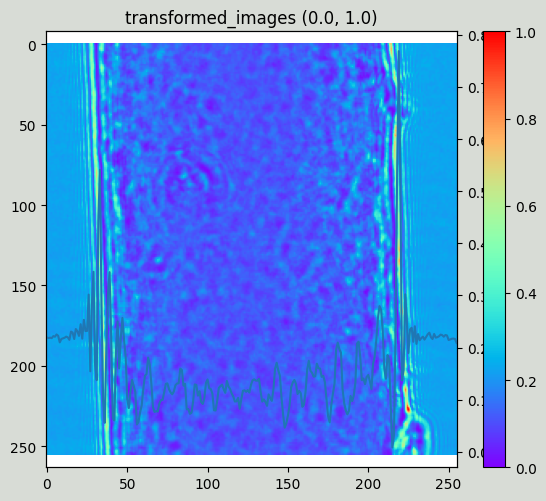

start training
epoch 0 gen_loss:  tensor(3.6489, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4862, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.1821, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  0.08896183967590332 remaining time:  26 seconds ssim:  0.27753055 psnr:  14.121521
epoch 59 gen_loss:  tensor(1.3679, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4762, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0538, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  3.589174270629883 remaining time:  21 seconds ssim:  0.5486884 psnr:  21.802166
epoch 119 gen_loss:  tensor(1.1201, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4917, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0378, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  6.666823148727417 remaining time:  16 seconds ssim:  0.57112294 psnr:  23.447338
epoch 179 gen_loss:  tensor(1.0403, device='cuda:1', grad_fn=<AddBackward0>

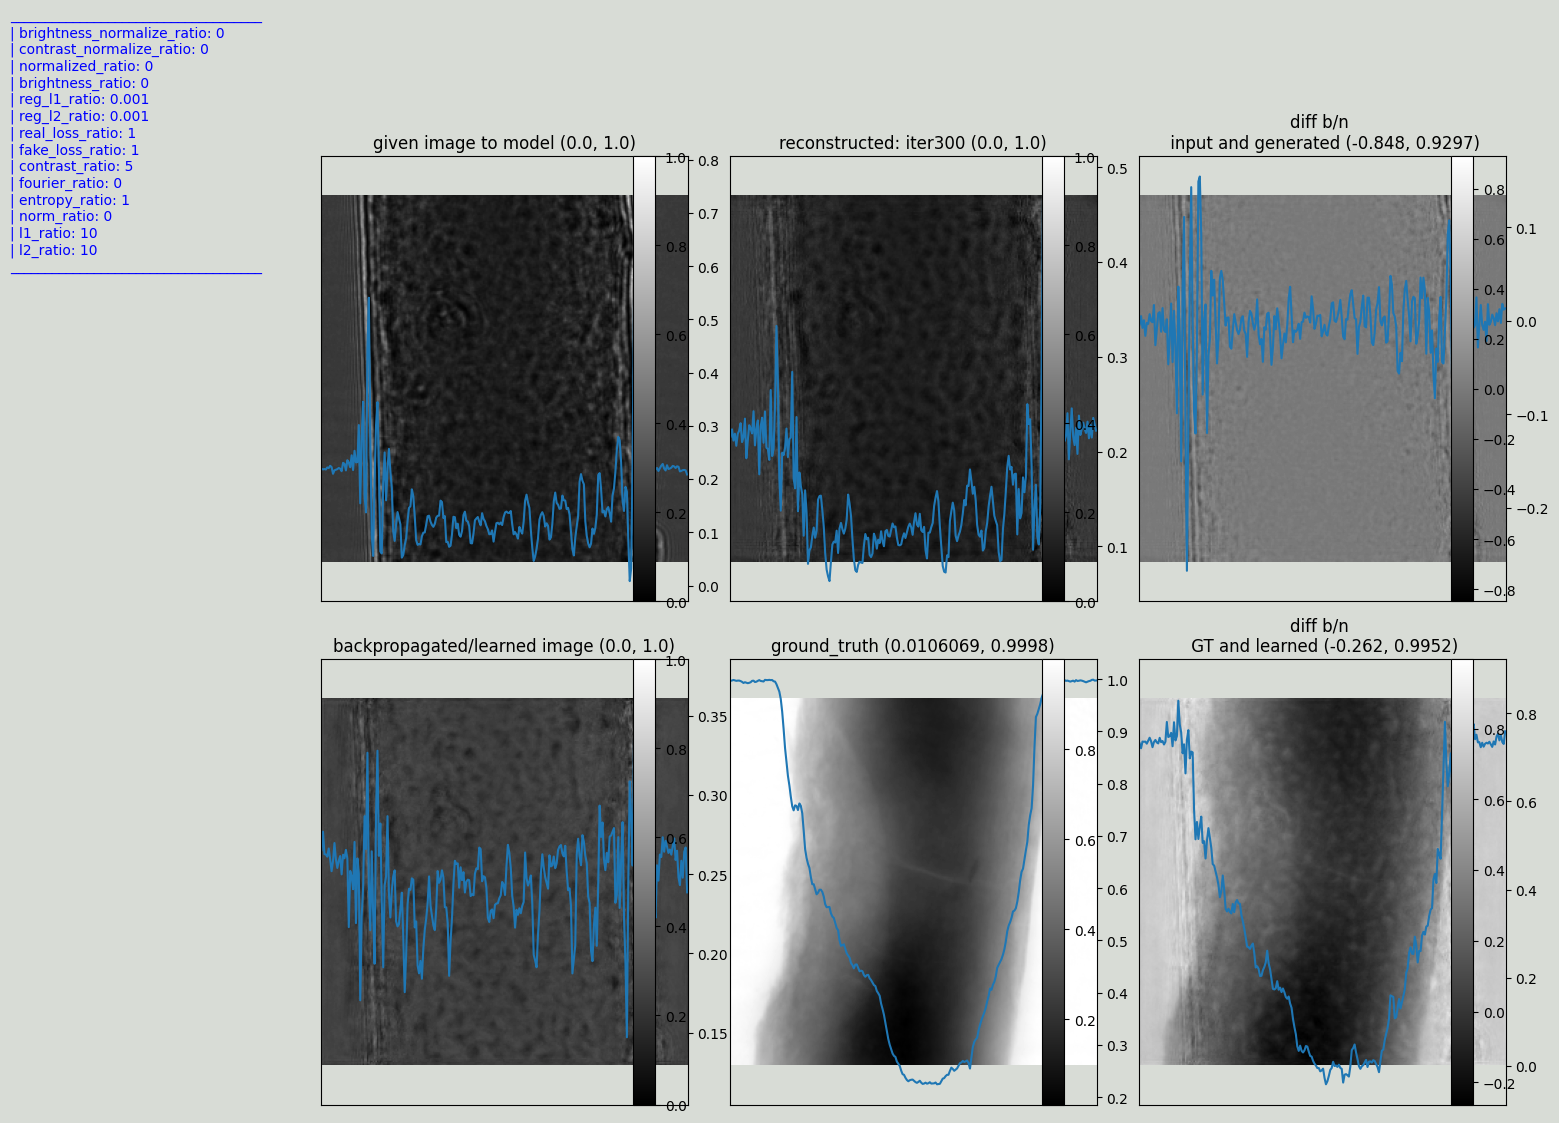

rows:  2 cols:  5
rows:  2 cols:  5


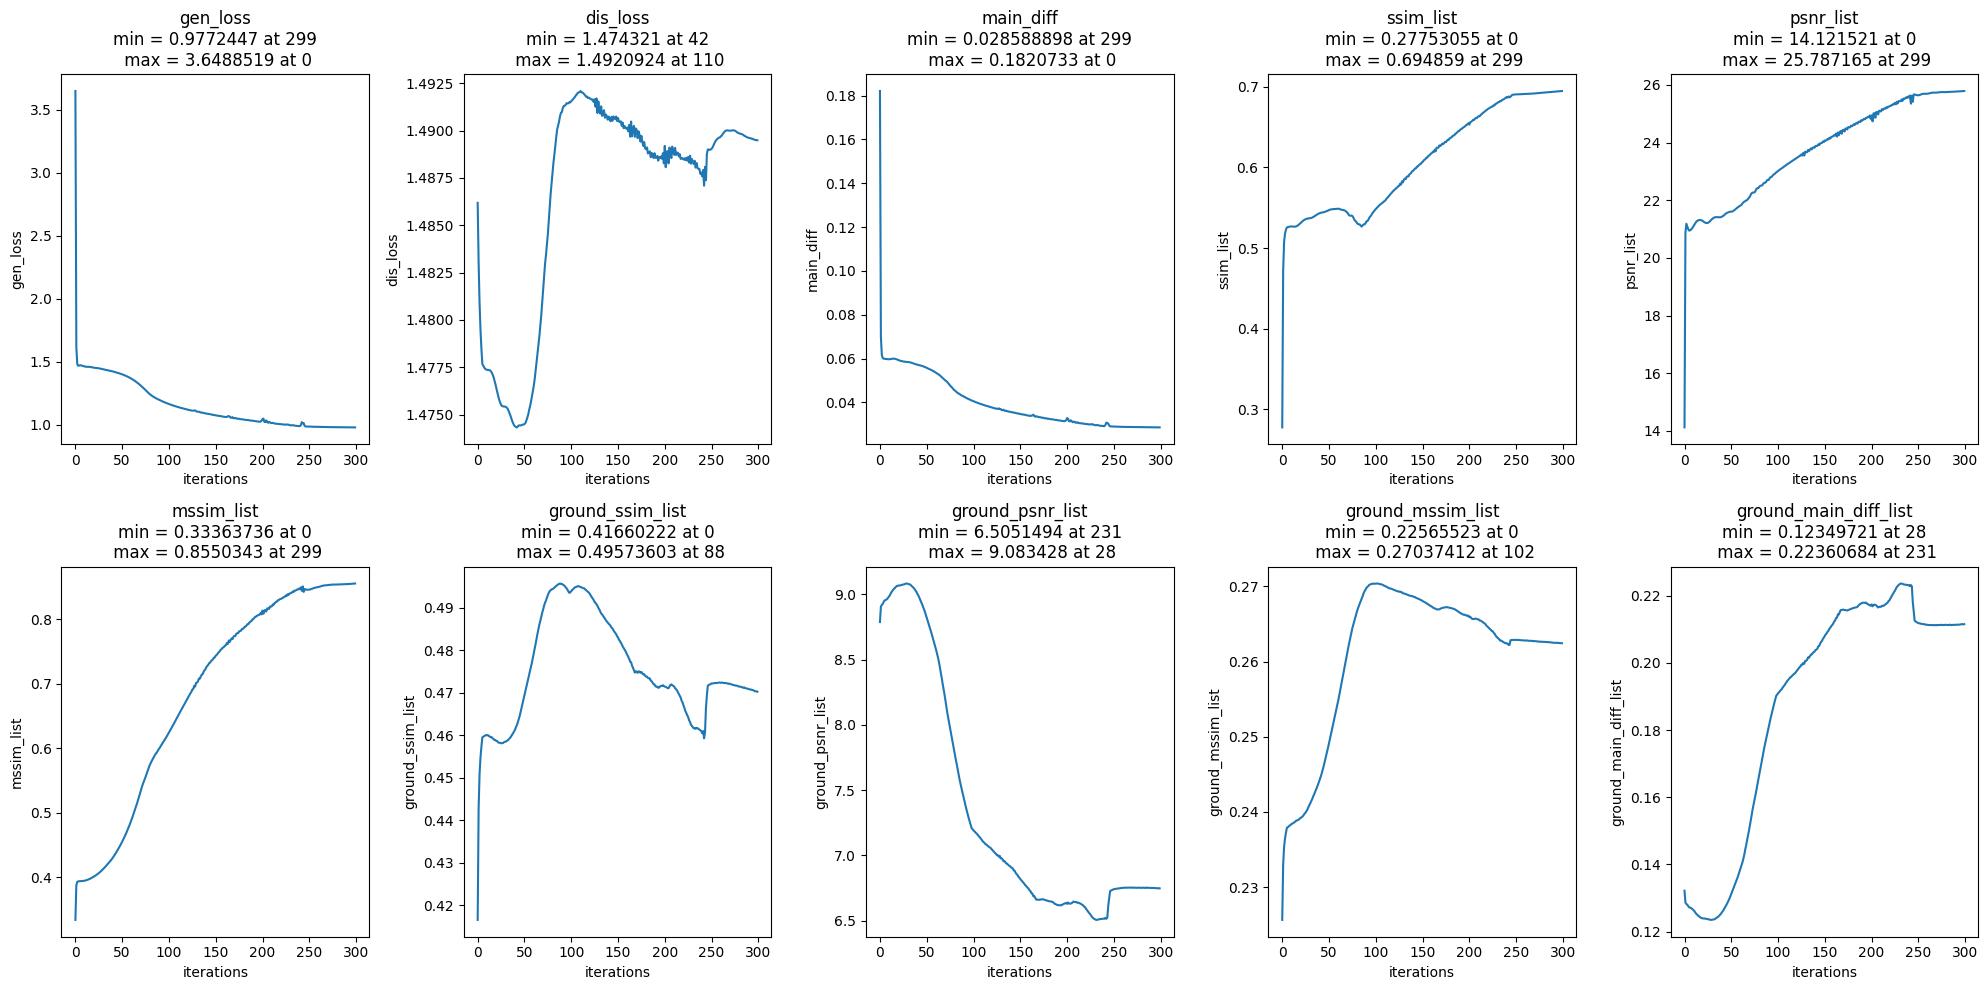

In [511]:
ratio = {'l1_ratio': 10, 'contrast_ratio': 5, 'normalized_ratio': 0, 'brightness_ratio': 0, 'reg_l1_ratio': 0.001, 'reg_l2_ratio': 0.001, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 10, 'fourier_ratio': 0, 'norm_ratio': 0, 'entropy_ratio': 1, 'real_loss_ratio': 1, 'fake_loss_ratio': 1}

model = make_ganrec_model(**jh)
visualize([model.transformed_images], title = ['transformed_images', 'transformed_images_transformed'], cmap = 'rainbow', show_or_plot='both' )
# model.generator_model
x = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
y = model.visualize(show_or_plot = 'both', cmap = 'gray', dict = ratio)

In [20]:
def fresnel_calc(energy, z, pv):
    """z and pv have to in meters"""
    if energy is None or z is None or pv is None:
        return None
    if type(energy) is not list and type(z) is not list and type(pv) is not list:
        wavelength = wavelength_from_energy(eneryg_J(energy)).magnitude
        fresnel_number = pv**2/(wavelength*z) 
    else:
        energy = [energy] if type(energy) is not list else energy
        wavelength = [wavelength_from_energy(eneryg_J(ener)).magnitude for ener in energy]
        z = [z] if type(z) is not list else z
        pv = [pv] if type(pv) is not list else pv
        fresnel_number = []
        for i in range(len(energy)):
            for j in range(len(z)):
                for k in range(len(pv)):
                    fresnel_number.append(pv[k]**2/(wavelength[i]*z[j]))
    return  fresnel_number

z_eff = [(((1.9127e+10)* 534000000)/(534000000 + 1.9127e+10)), (((1.9127e+10)* 536000000)/(536000000 + 1.9127e+10))]
M = np.divide(1.9127e+10, z_eff)
pv_eff = np.divide(6500, M)
lam = 0.1127e-9
fresnel_number = np.power(pv_eff, 2)/np.multiply(lam, z_eff)*1e-9
print(M, z_eff, 6500/M, F)
fresnel_calc(energy_from_wavelength(0.1127), z_eff,  pv_eff)


[36.81835206 36.68470149] [519496363.3589339, 521389004.7296954] [176.54239357 177.18557697] <module 'torch.nn.functional' from '/beegfs/desy/user/hailudaw/anacon/envs/topo/lib/python3.11/site-packages/torch/nn/functional.py'>


[array([0.00053234, 0.00053623]), array([0.00053041, 0.00053428])]

In [21]:

image = io.imread('/home/hailudaw/hailudaw/git_folders/ganrec/ganrectorch/data/JH/test_data_nano3649_holotomo_Mg2Ag_corr_1_130_angle.tiff')
jh ={
    'experiment_name': 'nano3649_holotomo_Mg2Ag_corr_1',
    'path': image,
    # 'phase': torch.fft.ifft2(torch.fft.fft2(torch_reshape(image)).angle()).real,
    # 'attenuation': torch.fft.ifft2(torch.fft.fft2(torch_reshape(image)).abs()).real,
    'energy': energy_from_wavelength(0.1127), 
    'fresnel_number': 0.1,# 5.3230e-04,
    'distance_sample_detector': 5.1950e+08,
    'detector_pixel_size': 176.5424,
    'downsampling_factor': 4,
    'z02': 1.9661e+10, 
    'z01': [534000000, 536000000][0],
    'z12': [1.9127e+10, 1.9125e+10][0],
    'z_eff': [5.1950e+08, 5.2139e+08][0],
    'dxeff': [176.5424, 177.2036][0],
    'M': [36.8184, 36.6810],
    'F_calc': [5.3230e-04, 5.3435e-04][0],
    'F_rescaled': [5.3230e-04, 5.3037e-04][0],
}

info = {
    'downsampling_factor': 16,
    'transform_factaor': 0.7,
    'transform_type': 'norm',
    'mode': 'reflect',
    'value': 'min',
    'device': 'cuda:0',
    'iter_num': 200,
    'abs_ratio': 1,
    'input_channels': 1,
    'output_num':2,
    'task': 'learn_phase',
    'seed': 49,
    'fc_depth': 0,
    'units': 1024,
    'cnn_depth': 0,
    'dis_depth': 3,
    'stride':1,
    'depth':3,
    'conv_num':32,
    'apply_batchnorm': True,
    'normal_init': True,
    'ground_truth': None,
}
ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 0, 'brightness_ratio': 0, 'reg_l1_ratio': 0.001, 'reg_l2_ratio': 0.001, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 0, 'norm_ratio': 0, 'entropy_ratio': 1, 'real_loss_ratio': 1, 'fake_loss_ratio': 1}
  
info.update(**jh)
dataloader = Ganrec_Dataloader(**info)
ratio_names = ['l1_ratio', 'contrast_ratio', 'normalized_ratio', 'brightness_ratio', 'reg_l1_ratio', 'reg_l2_ratio', 'contrast_normalize_ratio', 'brightness_normalize_ratio', 'l2_ratio', 'fourier_ratio', 'norm_ratio', 'entropy_ratio', 'real_loss_ratio', 'fake_loss_ratio']
model = make_ganrec_model(**dataloader.__dict__)
x = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
# y = model.visualize(show_or_plot = 'both', cmap = 'gray', dict = ratio)

TypeError: cannot assign 'list' as child module 'fc_stack' (torch.nn.Module or None expected)

using rows:  1 cols:  4


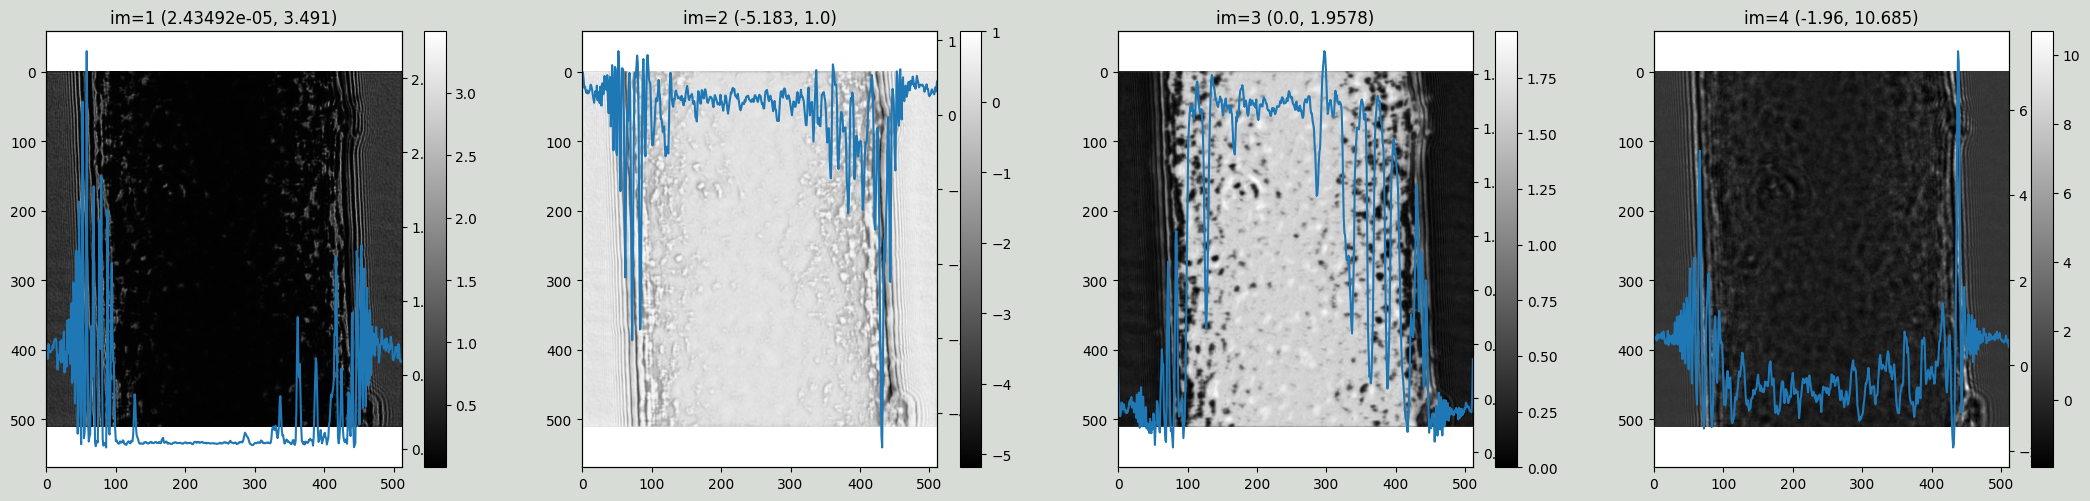

In [4]:
visualize([model.transformed_images, model.propagated_intensity_list[-1], model.phase_list[-1], model.attenuation_list[-1]], show_or_plot='both', cmap='gray')

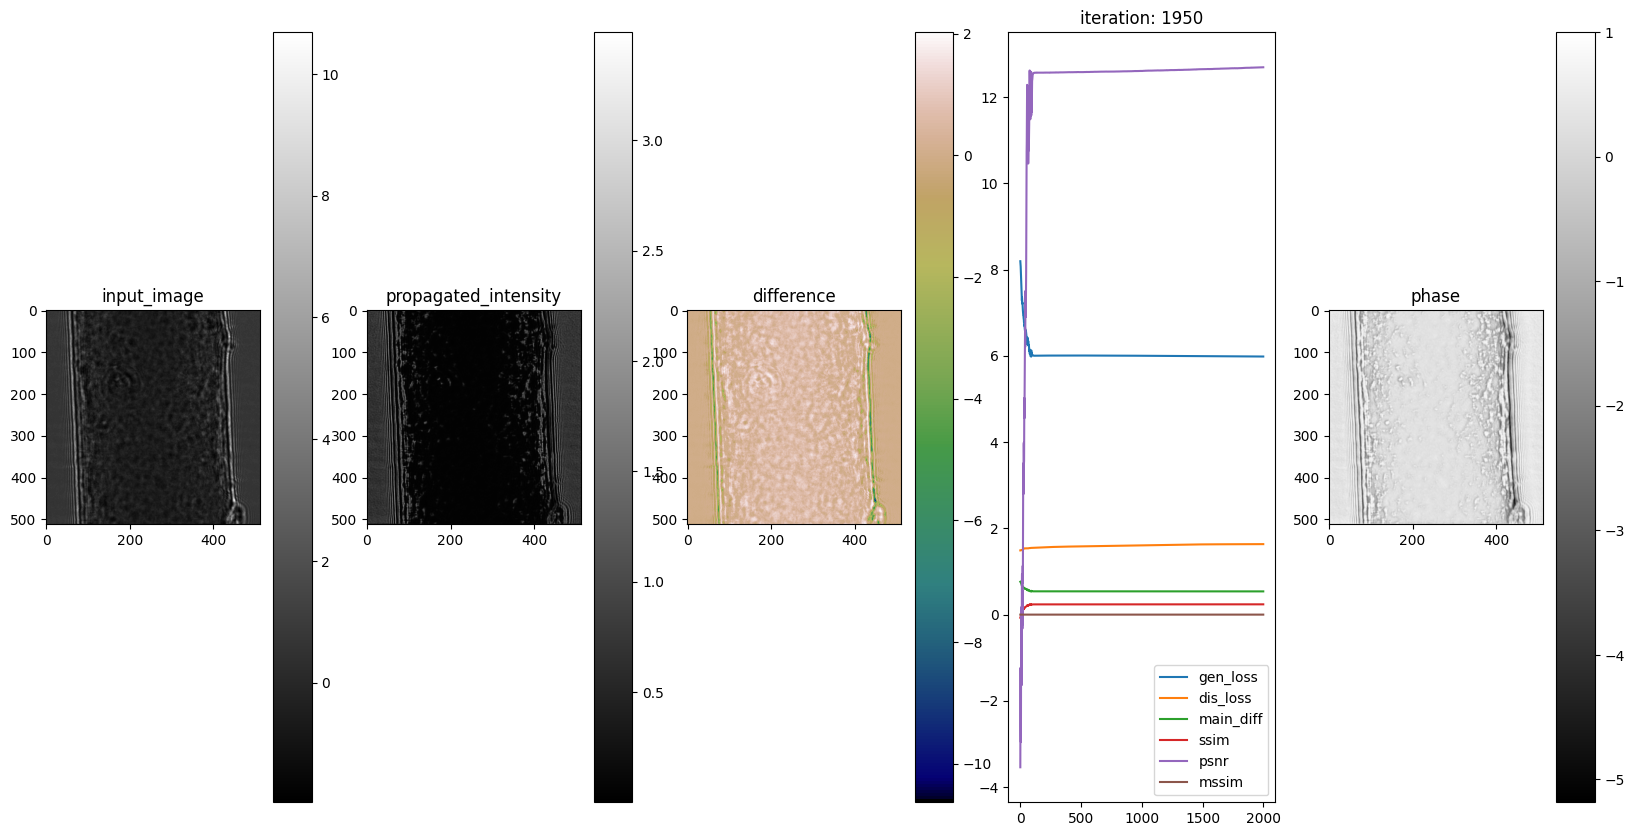

In [5]:
model.live_plot(rate = 50)

using rows:  1 cols:  2


ValueError: 'Green_r' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

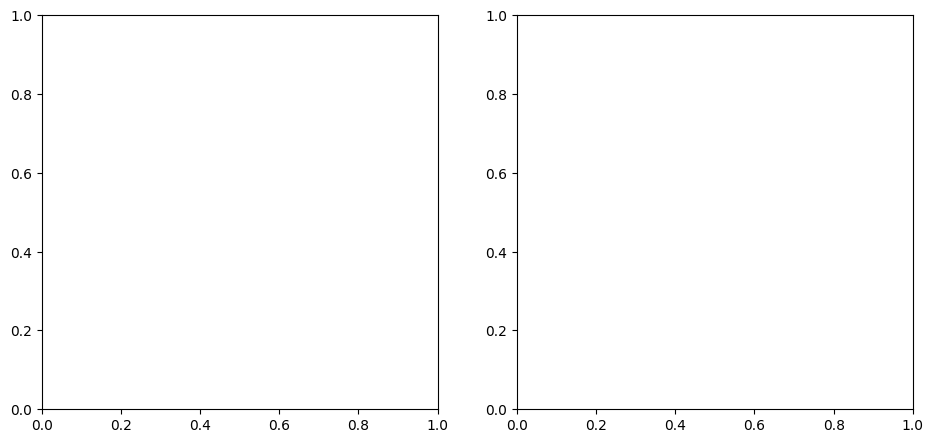

In [12]:
visualize([model.transformed_images, model.phase], title = ['input', 'phase'], show_or_plot='both', cmap='Green_r')

In [29]:
spider_hair_images = io.imread('data/gan_phase/data_spider.tif')
spider_hair = {
    'path': spider_hair_images,
    'experiment_name': 'spider_hair',
    'energy_kev': 11,
    'pv': 1.04735263e-7,
    'z': 7.8880960e-2,
    'idx': [120],
}

spider_hair_best = {
    'path': spider_hair_images,
    'experiment_name': 'spider_hair',
    'energy_kev': 11.2999999,
    'pv': 1.04735263e-7,
    'z': 7.8880960e-2,
    'idx': [120],

}

samis_mouse_images = io.imread_collection('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/' + '/*.tiff')
sami_mouse_good = {
    'path':  samis_mouse_images,
    'idx': [680],#[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.9191507469051687,
}

sami_best_distance = {
    'path':  samis_mouse_images,
    'idx': [680], #[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.90664,
    'abs_ratio': 0.039,
    'iter_num': 100,
    'abs_ratio': 0.00078,
    # 'phase': camera(),
    # 'fresnel_number': 0.00078,
}

sami_farther = {
    'path': samis_mouse_images,
    'idx': [680], #[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.95,
}
sami_closer = {
    'path':  samis_mouse_images,
    'idx': [680],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.9,
}   

sami_spider_image = io.imread('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111200_spiderh_750/logs/nano111200_spiderh_750_reco_single/2023-10-27_16-25-04_flatfield_corrected.tiff')
info_sami_spider = {
    'path': sami_spider_image,
    'experiment_name': 'sami_spider',
    'energy_kev': 11.0,
    'pv': 9.193699824924853e-08,
    'z': 0.2769425256194748 #0.0010809961997837324,
}

camera_prop = {
    'path': camera(),
    'phase': camera(),
    'energy_kev': 11, 
    'attenuation': camera(),
    'fresnel_number': 0.78,
}
info = {
    'downsampling_factor':1,
    'transform_factaor': 0.1,
    'transform_type': 'norm',
    'mode': 'reflect',
    'value': 'min',
    'device': 'cuda:1',
    'iter_num': 210,
    'abs_ratio': 1,
    'output_channel': 1,
    'output_num':2,
    'task': 'learn_phase',
    'seed': 49,
    'fc_depth': 0,
    'units': 128,
    'cnn_depth': 0,
    'dis_depth': 1,
    'stride':1,
    'depth':6,
    'apply_batchnorm': False,
    'normal_init': True,
}


info.update(camera_prop)
prepare_dict(**info)
# dataloader = Ganrec_Dataloader(**info)
# g = dataloader.visualize(cmap = 'gray')
# visualize([dataloader.forward_propagate(), dataloader.fresnel_factor.real, dataloader.fresnel_factor.real, np.abs(dataloader.fresnel_factor)], title = ['propagated_intensity', 'fresnel_factor.real', 'fresnel_factor.imag'])
# dataloader.forward_propagate().shape

{'downsampling_factor': 1,
 'transform_factaor': 0.1,
 'transform_type': 'norm',
 'mode': 'reflect',
 'value': 'min',
 'device': 'cuda:1',
 'iter_num': 210,
 'abs_ratio': 1,
 'output_channel': 1,
 'output_num': 2,
 'task': 'learn_phase',
 'seed': 49,
 'fc_depth': 0,
 'units': 128,
 'cnn_depth': 0,
 'dis_depth': 1,
 'stride': 1,
 'depth': 6,
 'apply_batchnorm': False,
 'normal_init': True,
 'path': array([[200, 200, 200, ..., 189, 190, 190],
        [200, 199, 199, ..., 190, 190, 190],
        [199, 199, 199, ..., 190, 190, 190],
        ...,
        [ 25,  25,  27, ..., 139, 122, 147],
        [ 25,  25,  26, ..., 158, 141, 168],
        [ 25,  25,  27, ..., 151, 152, 149]], dtype=uint8),
 'phase': array([[200, 200, 200, ..., 189, 190, 190],
        [200, 199, 199, ..., 190, 190, 190],
        [199, 199, 199, ..., 190, 190, 190],
        ...,
        [ 25,  25,  27, ..., 139, 122, 147],
        [ 25,  25,  26, ..., 158, 141, 168],
        [ 25,  25,  27, ..., 151, 152, 149]], dtype=uin

start training
epoch 0 gen_loss:  tensor(9.6496, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4967, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.9090, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  0.05678749084472656 remaining time:  5 seconds ssim:  0.1723715 psnr:  22.062166
epoch 49 gen_loss:  tensor(1.1771, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4962, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0611, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  2.413640022277832 remaining time:  2 seconds ssim:  0.99106455 psnr:  43.532444
epoch 99 gen_loss:  tensor(0.8594, device='cuda:1', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4993, device='cuda:1', grad_fn=<AddBackward0>) main_diff:  tensor(0.0292, device='cuda:1', grad_fn=<MeanBackward0>) t_epoch:  4.765292644500732 remaining time:  0 seconds ssim:  0.99515635 psnr:  49.66028
____________________________________
| brightness_normalize_ratio: 0 
| contrast

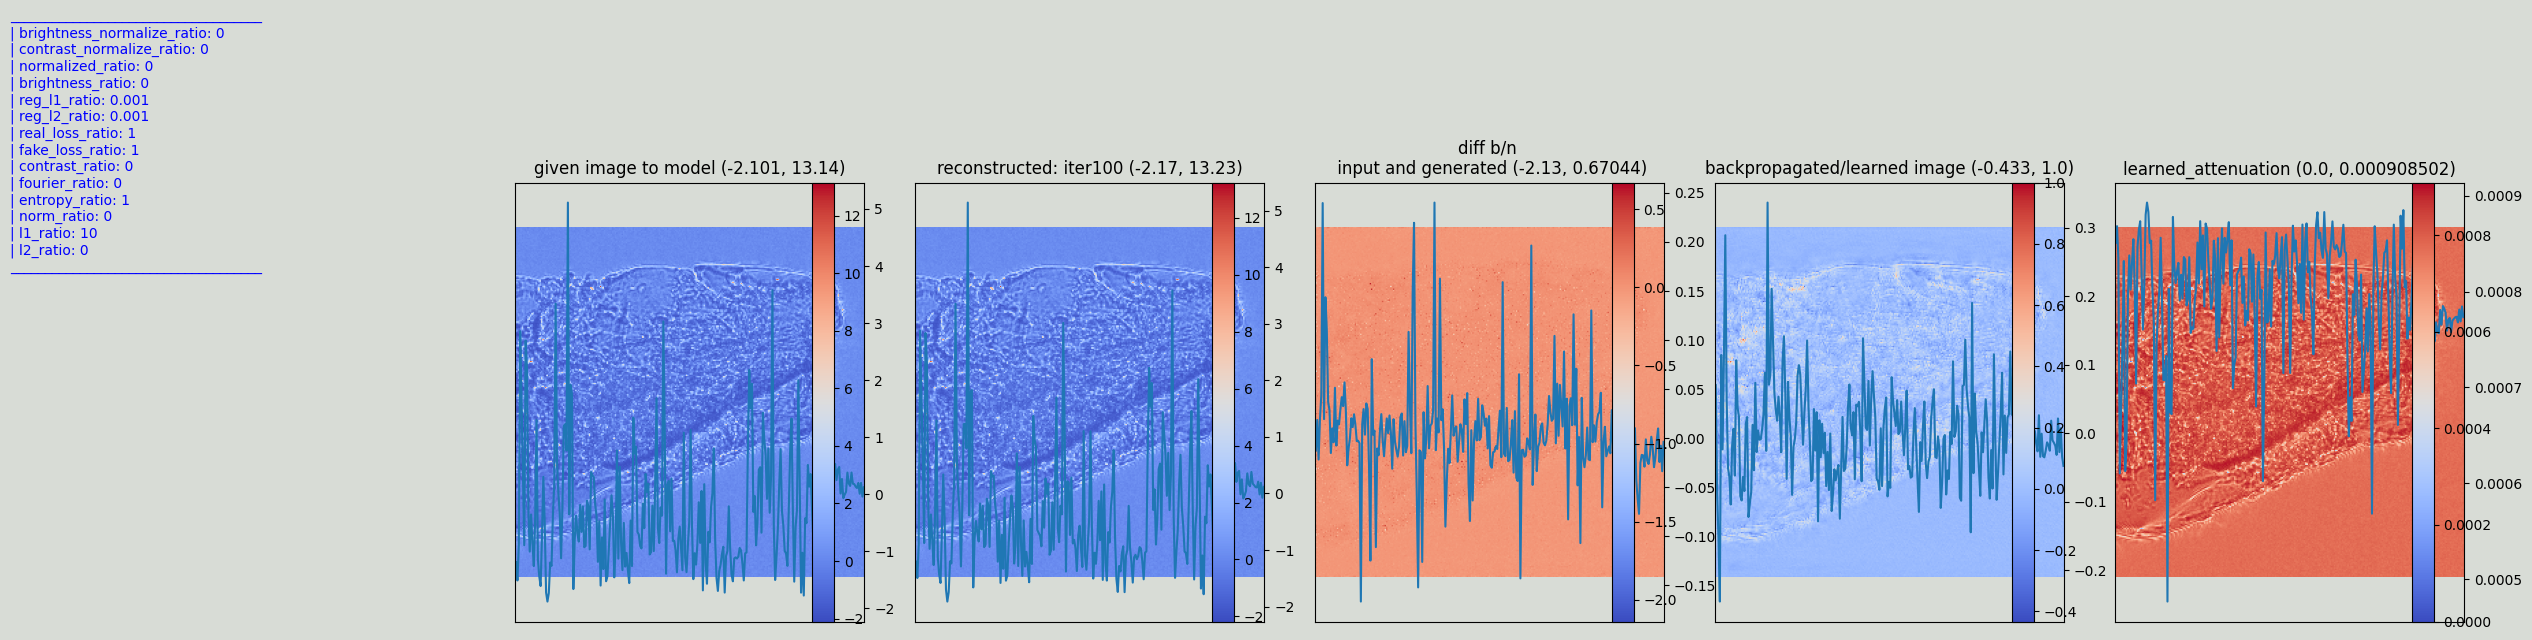

rows:  2 cols:  3
rows:  2 cols:  3


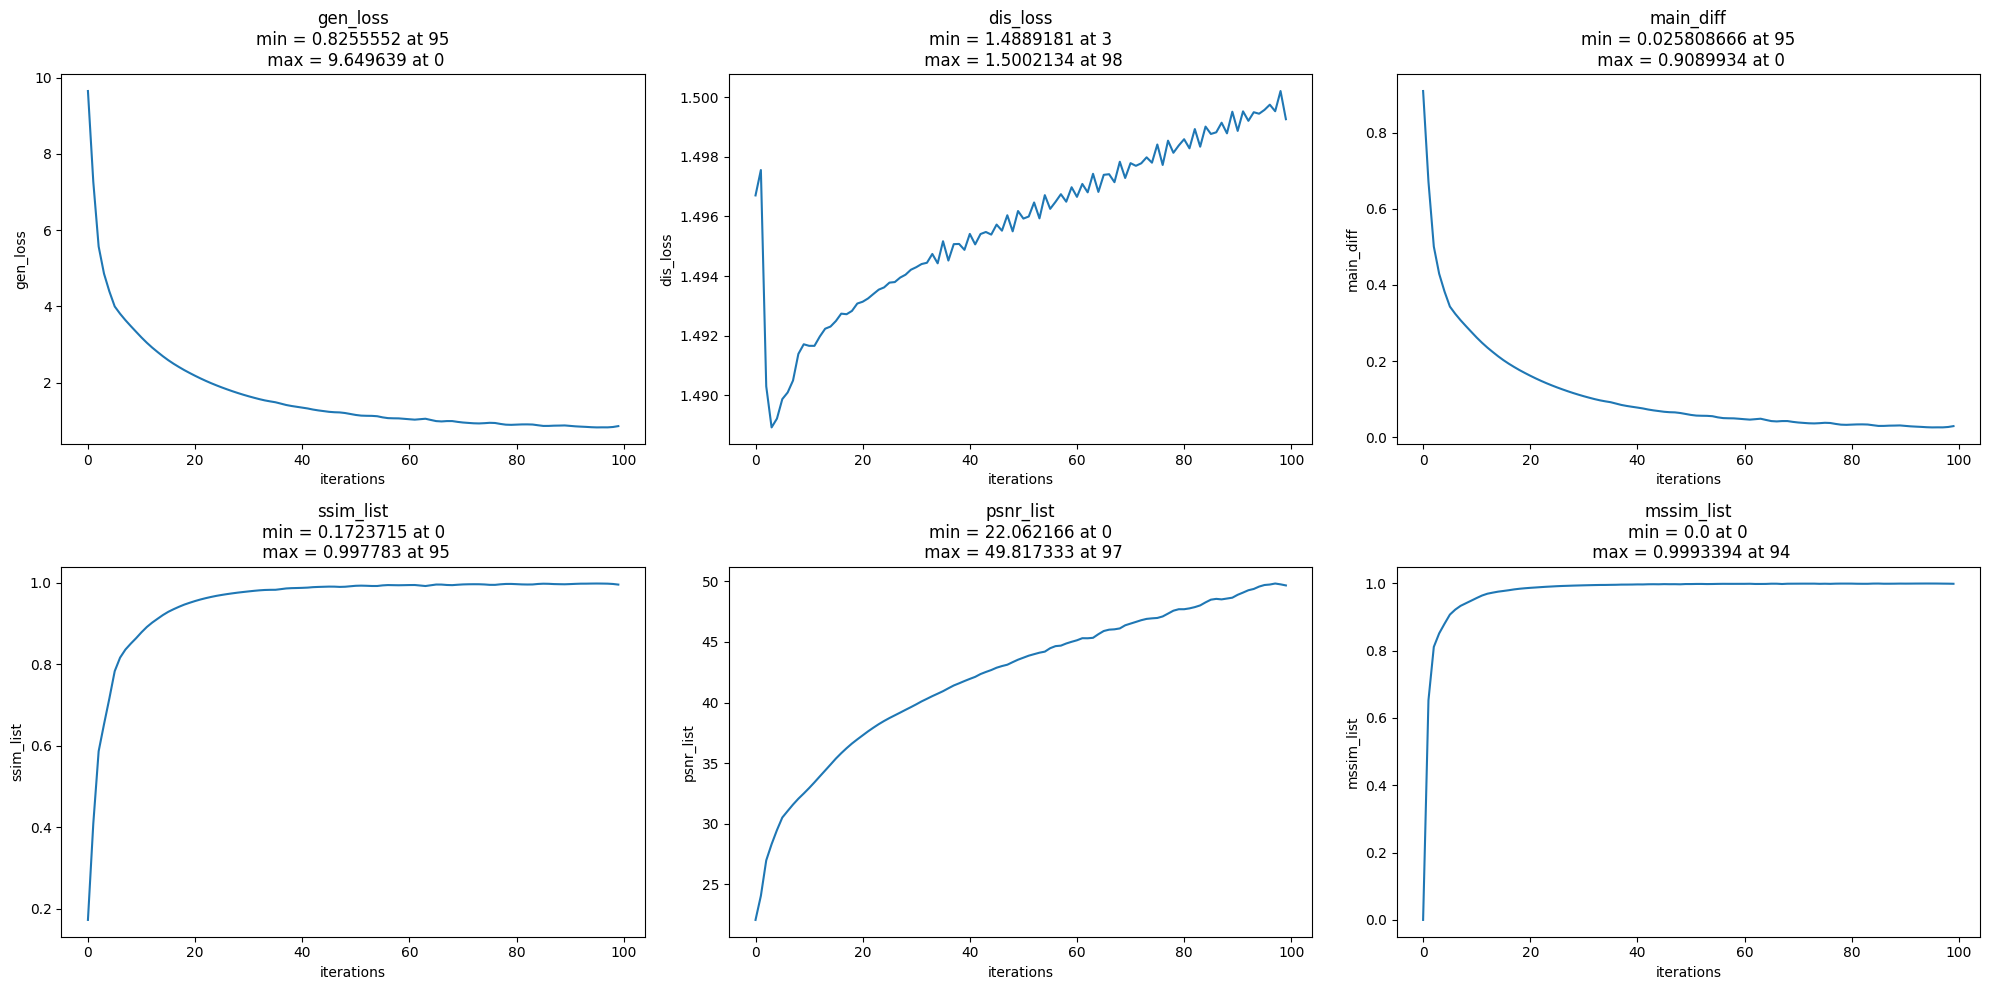

In [ ]:
ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 0, 'brightness_ratio': 0, 'reg_l1_ratio': 0.001, 'reg_l2_ratio': 0.001, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 0, 'norm_ratio': 0, 'entropy_ratio': 1, 'real_loss_ratio': 1, 'fake_loss_ratio': 1}
  
model = make_ganrec_model(**dataloader.__dict__)
x = model.train(save_model = False, save_model_path = 'model/ganrec_model', **ratio)
y = model.visualize(show_or_plot = 'both', cmap = 'coolwarm', dict = ratio)


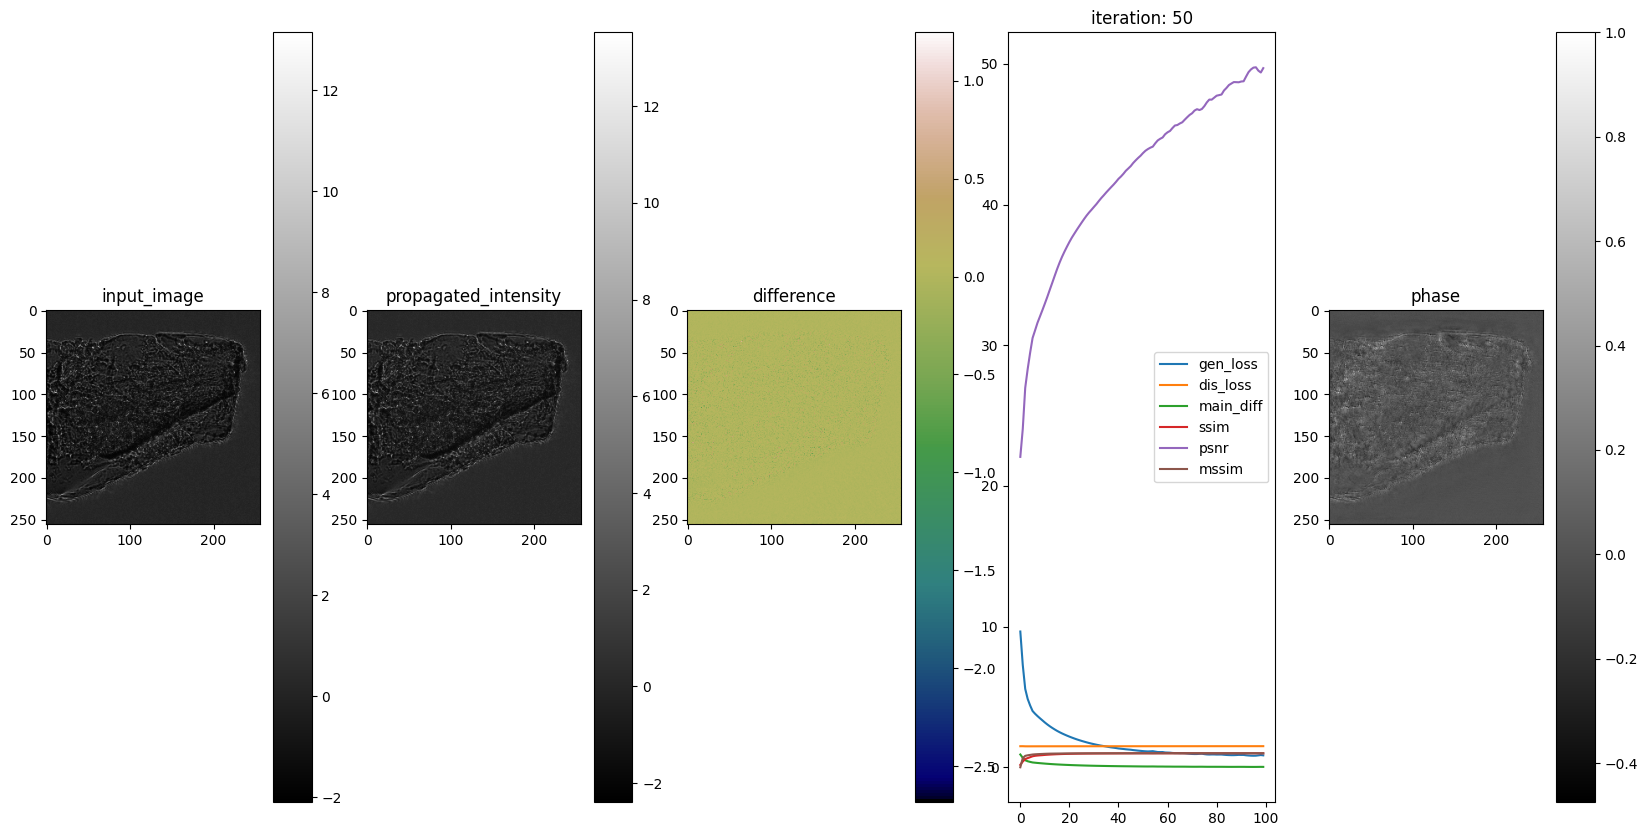

In [29]:
model.live_plot(rate = 50, cmap = 'gray')